## Bitcoin Fear & Greed Index
***

### Introduction
***
This is an attempt to create a sentiment index for Bitcoin. This sentiment index can be used for the purpose of trading into bitcoins and also as an indicator of overall mood. I have broadly divided the components of this index in two categories as follows.

**Market Sentiment**
 - Momentum
 - Implied Volatility (VIX)
 - Price / MA
 - Simulated Price (using Geometric Brownian Motion)
 
**Social Sentiment**
 - Google search trend
 - News
 - Reddit

### Methoodology
***
- **Momentum**: Momentum is calculated as $\frac{90dEMA - 30dEMA}{90dEMA}$


- **Implied Volatility**: Volatility Index is calculated using forecasted volatility using GARCH(1,1) model. Forecast for next 24 periods of volatility is made and calculated as $$\left ( \frac{VIX_t}{100} \right )^2 = \frac{1}{n}\sum_{k=1}^{n}E_{t}^{Q}\left [ \tilde{h}_{t+\frac{\tau_0 k}{n}} \right ]$$

  Refrence: Hao, J., & Zhang, J. E. (2013). GARCH option pricing models, the CBOE VIX, and variance risk premium. Journal of Financial Econometrics, 11(3), 556-580.


- **Price / 125d MA**


- **Google Search Trend**: Interest over time from google trends for the keyword 'bitcoin'


- **News**: Sentiment analysis using vaderSentiment api of news articles with 'bitcoin' keyword in their title


- **Reddit**: Top posts titles in subreddit r/bitcoin are captured and sentiment analysis using vaderSentiment is performed


In [14]:
import numpy as np
import pandas as pd
import glob
import json
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore")

## Momentum

In [5]:
df = pd.read_csv('./data/bitcoin.csv', sep = '\t')
df.Timestamp = pd.to_datetime(df.Timestamp) # convert timestamp to datetime format
df.replace(to_replace='—', value = '', inplace=True) # replace - values with blanks
df.set_index(df.Timestamp,drop=True,inplace=True) # set timestamp as index
df.drop(labels = 'Timestamp', axis = 1, inplace=True) # drop timestamp column

# convert data to numeric
df[['Open','High','Low','Volume (BTC)','Volume (Currency)','Weighted Price','Close']] = df[['Open','High','Low','Volume (BTC)','Volume (Currency)','Weighted Price','Close']].apply(pd.to_numeric)

df.fillna(method='ffill',inplace=True) # forward fill na values
df.head()

/home/cchopade/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Timestamp,,,,,,,
2012-12-31 00:00:00,13.2,13.2,13.20,13.20,0.23,3.04,13.20
2012-12-31 00:30:00,13.2,13.2,13.20,13.20,0.23,3.04,13.20
2012-12-31 01:00:00,13.2,13.2,13.18,13.18,2.28,30.05,13.18
2012-12-31 01:30:00,13.2,13.2,13.20,13.20,23.00,303.60,13.20
2012-12-31 02:00:00,13.2,13.2,13.20,13.20,23.00,303.60,13.20


Text(0.5,1,'Bitcoin Prices')

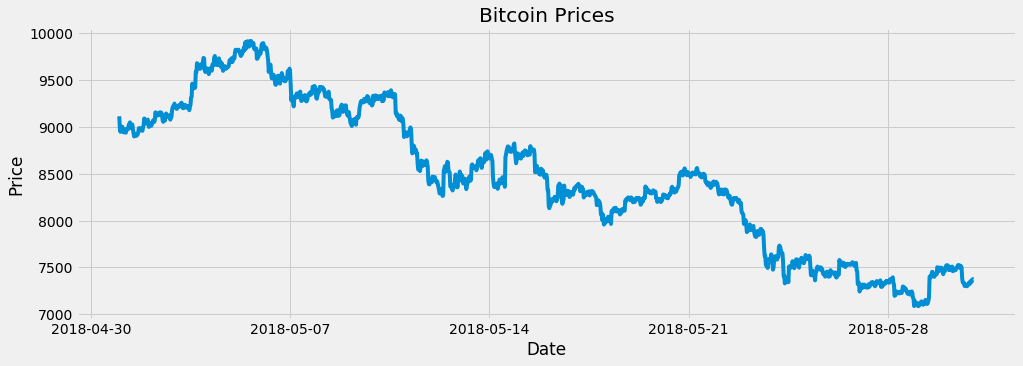

In [27]:
df2 = df.ix[datetime.date(year=2018,month=5,day=10):datetime.date(year=2018,month=5,day=31)].copy()
plt.figure(figsize=(15,5))
plt.plot(df2.index, df2.Close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Prices')

In [37]:
dfh  = pd.DataFrame()
dfh['close'] = df2.Close.resample('60Min', base = 30).last()


,close
Timestamp,
2018-04-30 23:30:00,9114.87
2018-05-01 00:30:00,8949.00
2018-05-01 01:30:00,8981.20
2018-05-01 02:30:00,8975.81
2018-05-01 03:30:00,8978.34
2018-05-01 04:30:00,8942.67
2018-05-01 05:30:00,8963.99
2018-05-01 06:30:00,8984.62
2018-05-01 07:30:00,9025.21


## News sentiment analysis

In [52]:
# get list of all files in the news data folder
files = glob.glob("/home/cchopade/crypto_hackathon/data/news/*.txt")

# initialize vaderSentiment object
analyzer = SentimentIntensityAnalyzer()

# create empty dataframe to store data
news_data = pd.DataFrame(columns = ['published','title','text','neg','neu','pos','compound'])

# loop through each file, parse text, perform sentiment analysis and store to dataframe
for file in files:
    with open(file) as json_file:  
        data = json.load(json_file)


    # create a blank dictionary to convert the data in a pandas dataframe
    news_dict = { "published":[],
                    "title":[],
                    "text":[], "neg":[],
                    "neu": [],
                    "pos": [],
                    "compound":[]}

    for news in data['posts']:
        news_dict["published"].append(news['published'])
        news_dict["title"].append(news['title'])
        news_dict["text"].append(news['text'])
        vs = analyzer.polarity_scores(news['text'])
        news_dict["neg"].append(vs['neg'])
        news_dict["neu"].append(vs['neu'])
        news_dict["pos"].append(vs['pos'])
        news_dict["compound"].append(vs['compound'])

    
    news_data = news_data.append(pd.DataFrame(news_dict),ignore_index=True)

news_data.to_csv('data/news_analysis.csv') # save processed data to csv for future use

/home/cchopade/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
